## Objective - Build a model to predict whether a customer is happy or not based on survey 

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.inspection import permutation_importance
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier,NearestCentroid
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier,PassiveAggressiveClassifier,Perceptron
from sklearn.svm import NuSVC

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Loading Dataset

In [35]:
data_url = ("/Users/vidyakumar/Desktop/python/apziva/ACME-HappinessSurvey2020.csv")

In [36]:
def load_data():
    data = pd.read_csv(data_url)
    return data

data = load_data()

data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [37]:
#renaming
data.columns = ['happiness_status', 'timely_delivery', 'expected_contents', 'complete_order', 'good_price', 'courier_satisfy', 'app_order_ease']
data.head()

,happiness_status,timely_delivery,expected_contents,complete_order,good_price,courier_satisfy,app_order_ease
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


## Exploratory Data Analysis

In [40]:
#checking for null values - has no null values
data.isnull().sum()

happiness_status     0
timely_delivery      0
expected_contents    0
complete_order       0
good_price           0
courier_satisfy      0
app_order_ease       0
dtype: int64

In [41]:
#dim of dataset
print(data.shape)

(126, 7)


In [27]:
#data description
print(data.describe())

       happiness_status  timely_delivery  expected_contents  complete_order  \
count            126.00           126.00             126.00          126.00   
mean               0.55             4.33               2.53            3.31   
std                0.50             0.80               1.11            1.02   
min                0.00             1.00               1.00            1.00   
25%                0.00             4.00               2.00            3.00   
50%                1.00             5.00               3.00            3.00   
75%                1.00             5.00               3.00            4.00   
max                1.00             5.00               5.00            5.00   

       good_price  courier_satisfy  app_order_ease  
count      126.00           126.00          126.00  
mean         3.75             3.65            4.25  
std          0.88             1.15            0.81  
min          1.00             1.00            1.00  
25%          3.00      

In [42]:
#checking for class balance
data['happiness_status'].value_counts()


1    69
0    57
Name: happiness_status, dtype: int64

##### Dataset has no null values. Imputation is not required.
##### The class of the output variable is balanced as 53% of the values belong to one class and 47% to another class. Oversampling or undersampling is not required.

## Split - Training and Testing data

In [43]:
#creating training and testing dataset
X = data.drop(columns = 'happiness_status')
y = data['happiness_status']
print(X.head())
print(y.head())

   timely_delivery  expected_contents  complete_order  good_price  \
0                3                  3               3           4   
1                3                  2               3           5   
2                5                  3               3           3   
3                5                  4               3           3   
4                5                  4               3           3   

   courier_satisfy  app_order_ease  
0                2               4  
1                4               3  
2                3               5  
3                3               5  
4                3               5  
0    0
1    0
2    1
3    0
4    0
Name: happiness_status, dtype: int64


In [44]:
X['Avg_rating']=X.apply(lambda a: a.mean(), axis=1)
X.head()

,timely_delivery,expected_contents,complete_order,good_price,courier_satisfy,app_order_ease,Avg_rating
0,3,3,3,4,2,4,3.17
1,3,2,3,5,4,3,3.33
2,5,3,3,3,3,5,3.67
3,5,4,3,3,3,5,3.83
4,5,4,3,3,3,5,3.83


In [46]:
X['5Rating_Count']=X.apply(lambda b:np.sum(b==5),axis=1)
X.head()

,timely_delivery,expected_contents,complete_order,good_price,courier_satisfy,app_order_ease,Avg_rating,5Rating_Count
0,3,3,3,4,2,4,3.17,0
1,3,2,3,5,4,3,3.33,1
2,5,3,3,3,3,5,3.67,2
3,5,4,3,3,3,5,3.83,2
4,5,4,3,3,3,5,3.83,2


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,random_state = 0)
print(y_test.head())
print(X_train.shape)
print(X_test.shape)

8     0
50    1
43    0
24    1
63    0
Name: happiness_status, dtype: int64
(100, 8)
(26, 8)


## Modeling

### 1.Logistic Regression - 58% Accuracy, AUC 64%

In [53]:
#logistic regression
logisticRegr = LogisticRegression()
lr = logisticRegr.fit(X_train, y_train)
y_pred=logisticRegr.predict(X_test)

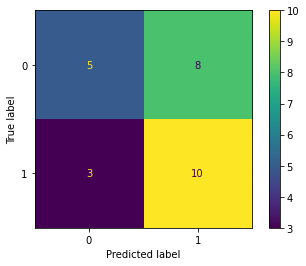

In [54]:
plot_confusion_matrix(logisticRegr, X_test, y_test)
plt.show()

In [55]:
#accuracy of 62%-Logistic regression
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.38      0.48        13
           1       0.56      0.77      0.65        13

    accuracy                           0.58        26
   macro avg       0.59      0.58      0.56        26
weighted avg       0.59      0.58      0.56        26



In [56]:
# predict probabilities 
y_prob=logisticRegr.predict_proba(X_test)
print(y_prob)

[[0.43444034 0.56555966]
 [0.36220809 0.63779191]
 [0.57671852 0.42328148]
 [0.55824865 0.44175135]
 [0.21292783 0.78707217]
 [0.68986676 0.31013324]
 [0.62656877 0.37343123]
 [0.29843802 0.70156198]
 [0.37801028 0.62198972]
 [0.49630339 0.50369661]
 [0.59205024 0.40794976]
 [0.37007138 0.62992862]
 [0.51242568 0.48757432]
 [0.17190222 0.82809778]
 [0.34468424 0.65531576]
 [0.40770674 0.59229326]
 [0.38143942 0.61856058]
 [0.51560369 0.48439631]
 [0.30175742 0.69824258]
 [0.34923031 0.65076969]
 [0.43854983 0.56145017]
 [0.22673261 0.77326739]
 [0.53832622 0.46167378]
 [0.27344636 0.72655364]
 [0.3148535  0.6851465 ]
 [0.34438407 0.65561593]]


In [57]:
# keep probabilities for the positive outcome only
probs = y_prob[:, 1]

In [126]:
# calculate roc auc
auc = roc_auc_score(y_test, probs)
print(auc)

0.6449704142011834


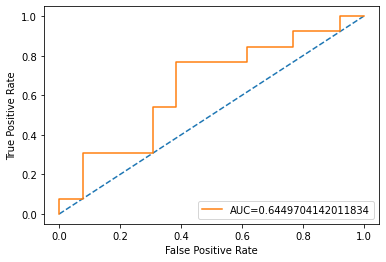

In [59]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# show the plot
plt.show()

##### The more that the curve hugs the top left corner of the plot, the better the model does at classifying the data into categories. As we can see from the plot above, this logistic regression model does a pretty poor job of classifying the data into categories

##### To quantify this, we can calculate the AUC – area under the curve – which tells us how much of the plot is located under the curve.Since AUC is 0.64, this confirms that the model does not do a job of classifying data.

### 2.SVM Classifier - 73% Accuracy

In [60]:
#create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#training the model
svmc = clf.fit(X_train, y_train)

#model prediction
y_pred_clf = clf.predict(X_test)

In [61]:
#accuracy of 69%-SVM
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

           0       1.00      0.46      0.63        13
           1       0.65      1.00      0.79        13

    accuracy                           0.73        26
   macro avg       0.82      0.73      0.71        26
weighted avg       0.83      0.73      0.71        26



### 3.KNN Classifier - 73% Accuracy

In [62]:
#knn classifier
k_range = range(1,50)                                
scores = {}                                          
score_list = []                                     
for k in k_range:                                    
    knn = KNeighborsClassifier(n_neighbors = k)     
    knn.fit(X_train, y_train)                        
    y_pred_knn = knn.predict(X_test)                 
    scores[k] = f1_score(y_test, y_pred_knn)         
    score_list.append(f1_score(y_test, y_pred_knn))  


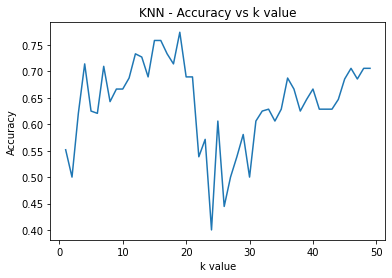

In [63]:
#identifying k value for best accuracy
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list)                   
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [64]:
#Max score of 74% occurs at k=10
print(max(score_list))
print(max(scores, key=scores.get))

0.7741935483870968
19


In [65]:
#building the final knn model with k=19
knnc = KNeighborsClassifier(n_neighbors = 19)     
knf = knnc.fit(X_train, y_train)                        
y_pred_knn = knnc.predict(X_test)                 


In [67]:
#knn accuracy 73%
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.88      0.54      0.67        13
           1       0.67      0.92      0.77        13

    accuracy                           0.73        26
   macro avg       0.77      0.73      0.72        26
weighted avg       0.77      0.73      0.72        26



In [68]:
# predict probabilities 
y_prob_knn=knnc.predict_proba(X_test)
print(y_prob_knn)

[[0.42105263 0.57894737]
 [0.47368421 0.52631579]
 [0.52631579 0.47368421]
 [0.47368421 0.52631579]
 [0.36842105 0.63157895]
 [0.47368421 0.52631579]
 [0.42105263 0.57894737]
 [0.42105263 0.57894737]
 [0.42105263 0.57894737]
 [0.52631579 0.47368421]
 [0.52631579 0.47368421]
 [0.52631579 0.47368421]
 [0.42105263 0.57894737]
 [0.36842105 0.63157895]
 [0.42105263 0.57894737]
 [0.52631579 0.47368421]
 [0.42105263 0.57894737]
 [0.52631579 0.47368421]
 [0.31578947 0.68421053]
 [0.47368421 0.52631579]
 [0.52631579 0.47368421]
 [0.26315789 0.73684211]
 [0.63157895 0.36842105]
 [0.31578947 0.68421053]
 [0.26315789 0.73684211]
 [0.26315789 0.73684211]]


In [69]:
# keep probabilities for the positive outcome only
knn_probs = y_prob_knn[:, 1]

In [70]:
# calculate roc auc
knn_auc = roc_auc_score(y_test, knn_probs)
print(knn_auc)

0.6479289940828402


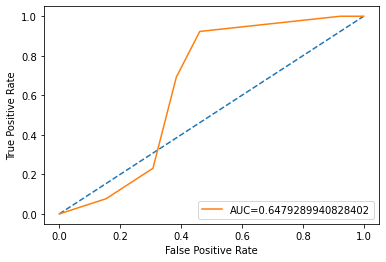

In [71]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, knn_probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr,tpr,label="AUC="+str(knn_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
# show the plot
plt.show()

### 4.Naives Bayes Classifier - 62% Accuracy

In [72]:
#Gaussian Classifier
gnb = GaussianNB()
nbc = gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

In [73]:
#naives bayes - 62% sccuracy
print(classification_report(y_test, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.60      0.69      0.64        13

    accuracy                           0.62        26
   macro avg       0.62      0.62      0.61        26
weighted avg       0.62      0.62      0.61        26



### 5.Decision Tree Classifier - 50% Accuracy

In [74]:
# DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 0)      
dtc.fit(X_train, y_train)                          
y_pred_dtc = dtc.predict(X_test)                    


In [75]:
#decision tree classifier accuracy - 50%
print(classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.50      0.54      0.52        13
           1       0.50      0.46      0.48        13

    accuracy                           0.50        26
   macro avg       0.50      0.50      0.50        26
weighted avg       0.50      0.50      0.50        26



### 6.SGD Classifier - 50% Accuracy

In [76]:
# SGDClassifier
sgd = SGDClassifier(shuffle=True, random_state=101)
sgd.fit(X_train, y_train)
y_pred_sgd=sgd.predict(X_test)

In [77]:
#sgd - 50% sccuracy
print(classification_report(y_test, y_pred_sgd))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.50      1.00      0.67        13

    accuracy                           0.50        26
   macro avg       0.25      0.50      0.33        26
weighted avg       0.25      0.50      0.33        26



##### Range of accuracy - 50% to 73%
##### KNN and SVM models give the best F1 score accuracy of 73%


## Feature Importance 

### 1. Permutation Importance

In [78]:
import eli5
from eli5.sklearn import PermutationImportance

perm_lr = PermutationImportance(lr, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm_lr, feature_names = X_test.columns.tolist())

Weight,Feature
0.0154 ± 0.1507,timely_delivery
0.0077 ± 0.1231,complete_order
0 ± 0.0000,Avg_rating
-0.0154 ± 0.0377,app_order_ease
-0.0154 ± 0.0377,courier_satisfy
-0.0231 ± 0.0377,good_price
-0.0538 ± 0.1341,5Rating_Count
-0.0615 ± 0.0615,expected_contents


In [79]:
perm_knn = PermutationImportance(knf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm_knn, feature_names = X_test.columns.tolist())

Weight,Feature
0.2000 ± 0.0576,courier_satisfy
0.1692 ± 0.0784,5Rating_Count
0.1538 ± 0.1088,good_price
0.1231 ± 0.1131,app_order_ease
0.1154 ± 0.1287,expected_contents
0.1000 ± 0.1584,timely_delivery
0.0385 ± 0.0843,Avg_rating
0.0077 ± 0.1569,complete_order


In [80]:
perm_svm = PermutationImportance(svmc, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm_svm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1154 ± 0.1946,timely_delivery
0.0846 ± 0.0576,complete_order
0.0692 ± 0.0754,5Rating_Count
0.0692 ± 0.0897,good_price
0.0385 ± 0.1287,expected_contents
0.0308 ± 0.0754,courier_satisfy
0.0154 ± 0.0615,Avg_rating
0.0154 ± 0.0784,app_order_ease


##### timelydelivery and goodprice is present top4 for all the above tables, considering the fact that KNN gave us the best result, we will choose timely_delivery, expected_contents, app_order_ease and good_price 


#### Modeling with Permutation Importance Top 4 Features

In [81]:
X_new = X[['timely_delivery', 'good_price', 'expected_contents', 'app_order_ease','5Rating_Count']]


In [82]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new,y, test_size = 0.2,random_state = 0)
print(X_test_new.head())


    timely_delivery  good_price  expected_contents  app_order_ease  \
8                 4           4                  1               4   
50                5           3                  1               4   
43                4           4                  3               4   
24                4           3                  3               4   
63                5           2                  5               5   

    5Rating_Count  
8               0  
50              1  
43              0  
24              0  
63              5  


In [83]:
#building knn with top 4 features
k_range = range(1,100)                                       
scores_new = {}                                             
score_list_new = []                                         
for k in k_range:                                           
    knn = KNeighborsClassifier(n_neighbors = k)              
    knn.fit(X_train_new, y_train_new)                       
    y_pred_knn = knn.predict(X_test_new)                    
    scores_new[k] = f1_score(y_test_new, y_pred_knn)         
    score_list_new.append(f1_score(y_test_new, y_pred_knn))  
    

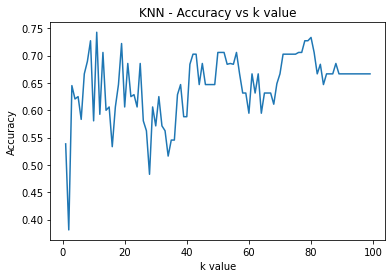

In [84]:
#identifying value of k for best accuracy
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list_new)                   
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [85]:
#Max score of 72% occurs at k=33
print(max(score_list_new))
print(max(scores_new, key=scores_new.get))

0.7428571428571429
11


In [86]:
#KNN Model with k=33
knn_f_new = KNeighborsClassifier(n_neighbors = 11)            
knn_f_new.fit(X_train_new, y_train_new)                        
y_pred_knn_f_new = knn_f_new.predict(X_test_new)              

In [87]:
print(classification_report(y_test_new, y_pred_knn_f_new))


              precision    recall  f1-score   support

           0       1.00      0.31      0.47        13
           1       0.59      1.00      0.74        13

    accuracy                           0.65        26
   macro avg       0.80      0.65      0.61        26
weighted avg       0.80      0.65      0.61        26



##### Excluding the 2 least important features led to a 8% decrease in F1 score(KNN Model). Hence, it would be best to retain all 6 variables.

In [88]:
#create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#training the model
svmc_new = clf.fit(X_train_new, y_train_new)

#model prediction
y_pred_clf_new = clf.predict(X_test_new)

In [89]:
print(classification_report(y_test_new, y_pred_clf_new))

              precision    recall  f1-score   support

           0       1.00      0.23      0.38        13
           1       0.57      1.00      0.72        13

    accuracy                           0.62        26
   macro avg       0.78      0.62      0.55        26
weighted avg       0.78      0.62      0.55        26



### 3. SHAP Feature Importance

In [90]:
#shap feature importance
import xgboost
import shap
model = xgboost.XGBRegressor().fit(X_train, y_train)
explainer = shap.TreeExplainer(model)                           # Explain the model using shap
shap_values = explainer.shap_values(X_train)                    # Get shap values for training data


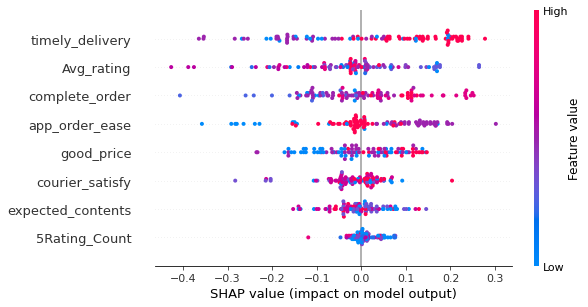

In [91]:
#Summary of feature importance for each row 
shap.summary_plot(shap_values, features = X_train, feature_names = X_train.columns) 


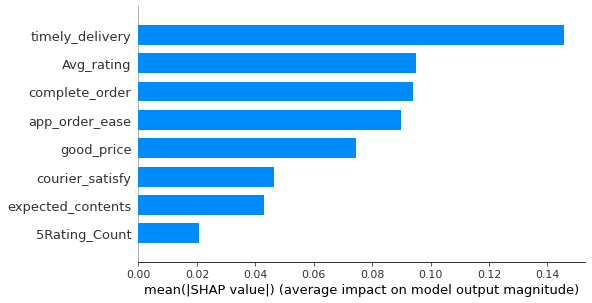

In [92]:
#Summary of feature importance using bar plot
shap.summary_plot(shap_values, features = X_train, feature_names = X_train.columns, plot_type = 'bar')


#### Modeling with SHAP Top 4 Features

In [104]:
#top4 features from shap
X_shap = X[['timely_delivery','app_order_ease', 'complete_order', 'good_price','Avg_rating']]


In [105]:
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(X_shap,y, test_size = 0.2,random_state=0)
print(X_test_shap.head())


    timely_delivery  app_order_ease  complete_order  good_price  Avg_rating
8                 4               4               4           4        3.50
50                5               4               3           3        3.33
43                4               4               3           4        3.33
24                4               4               3           3        3.33
63                5               5               5           2        4.50


In [106]:
#knn with top 4 features from shap
k_range = range(1,100)                                       
scores_shap = {}                                              
score_list_shap = []                                          
for k in k_range:                                            
    knn = KNeighborsClassifier(n_neighbors = k)              
    knn.fit(X_train_shap, y_train_shap)                        
    y_pred_knn = knn.predict(X_test_shap)                     
    scores_shap[k] = f1_score(y_test_shap, y_pred_knn)         
    score_list_shap.append(f1_score(y_test_shap, y_pred_knn)) 
    

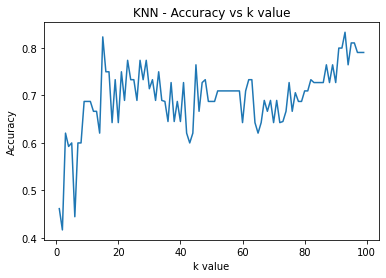

In [96]:
#identifying value of k for best accuracy
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list_shap)                   
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

In [107]:
print(max(score_list_shap))
print(max(scores_shap, key=scores_shap.get))


0.7027027027027027
84


##### Excluding the 2 least important variables leads to a decrease in F1 score by 3%. Hence, it would be best to retain all 6 variables.

##### Overall, removing features is decreasing the accuracy, this could be because the dataset is small and has only 6 features

In [108]:
#create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#training the model
svmc_shap = clf.fit(X_train_shap, y_train_shap)

#model prediction
y_pred_clf_shap = clf.predict(X_test_shap)

In [109]:
print(classification_report(y_test_shap, y_pred_clf_shap))

              precision    recall  f1-score   support

           0       0.80      0.31      0.44        13
           1       0.57      0.92      0.71        13

    accuracy                           0.62        26
   macro avg       0.69      0.62      0.58        26
weighted avg       0.69      0.62      0.58        26



## Bagging Technique (Ensemble)

In [110]:
#applying bagging technique to knn
h=BaggingClassifier(KNeighborsClassifier(n_neighbors=10),max_samples=0.7,max_features=0.7,n_estimators=1000)

In [111]:
#applying bagging to our knn model reduced accuracy to 54%
h.fit(X_train,y_train)
y_pred_bag=h.predict(X_test)
print(classification_report(y_test,y_pred_bag))

              precision    recall  f1-score   support

           0       0.80      0.31      0.44        13
           1       0.57      0.92      0.71        13

    accuracy                           0.62        26
   macro avg       0.69      0.62      0.58        26
weighted avg       0.69      0.62      0.58        26



##### Since KNN gave the best result,tried bagging technique on the KNN model, but that did not work as expected. It reduced model accuracy by 20%

## Lazy Predict

### All Features

In [112]:
#using lazypredict to identify other models which might improve accuracy - all features
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)


100%|██████████| 29/29 [00:00<00:00, 37.59it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreeClassifier                0.65               0.65     0.65      0.65   
NearestCentroid                    0.65               0.65     0.65      0.65   
LGBMClassifier                     0.62               0.62     0.62      0.61   
BaggingClassifier                  0.62               0.62     0.62      0.61   
XGBClassifier                      0.62               0.62     0.62      0.61   
GaussianNB                         0.62               0.62     0.62      0.61   
LabelPropagation                   0.62               0.62     0.62      0.61   
LabelSpreading                     0.62               0.62     0.62      0.61   
RidgeClassifierCV                  0.58               0.58     0.58      0.56   
RidgeClassifier                    0.58               0.58     0.58      0.56   
RandomForestClassifier      

### Permutation Importance Features

In [113]:
#using lazypredict to identify other models which might improve accuracy - perm features
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_new, X_test_new, y_train_new, y_test_new)
print(models)

100%|██████████| 29/29 [00:00<00:00, 36.52it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.73               0.73     0.73      0.73   
PassiveAggressiveClassifier        0.73               0.73     0.73      0.73   
GaussianNB                         0.69               0.69     0.69      0.69   
NearestCentroid                    0.69               0.69     0.69      0.69   
LinearSVC                          0.65               0.65     0.65      0.65   
LogisticRegression                 0.65               0.65     0.65      0.65   
LinearDiscriminantAnalysis         0.65               0.65     0.65      0.65   
RidgeClassifierCV                  0.65               0.65     0.65      0.65   
RidgeClassifier                    0.65               0.65     0.65      0.65   
SGDClassifier                      0.62               0.62     0.62      0.59   
LabelSpreading              

### SHAP Features

In [114]:
#using lazypredict to identify other models which might improve accuracy - shap features
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_shap, X_test_shap, y_train_shap, y_test_shap)
print(models)

100%|██████████| 29/29 [00:00<00:00, 38.53it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BaggingClassifier                  0.65               0.65     0.65      0.65   
LabelPropagation                   0.65               0.65     0.65      0.65   
LinearSVC                          0.62               0.62     0.62      0.59   
SGDClassifier                      0.62               0.62     0.62      0.59   
CalibratedClassifierCV             0.62               0.62     0.62      0.55   
RidgeClassifierCV                  0.62               0.62     0.62      0.59   
RidgeClassifier                    0.62               0.62     0.62      0.59   
NearestCentroid                    0.62               0.62     0.62      0.61   
GaussianNB                         0.62               0.62     0.62      0.61   
LabelSpreading                     0.62               0.62     0.62      0.62   
LogisticRegression          

##### Let's proceed to build models based on the top models predicted by Lazy predict

## Lazy Predict Top Models

### 1. SGD with SHAP Variables - 62% Accuracy

In [115]:
#sgd with 4 variables(shap) improved accuracy from 54% to 62%
sgd = SGDClassifier(shuffle=True, random_state=101)
sgd.fit(X_train_shap, y_train_shap)
y_pred_sgd=sgd.predict(X_test_shap)

In [116]:
print(classification_report(y_test_shap, y_pred_sgd))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.50      1.00      0.67        13

    accuracy                           0.50        26
   macro avg       0.25      0.50      0.33        26
weighted avg       0.25      0.50      0.33        26



### 2. Nearest Centroid Classifier with PERM Variables - 77% Accuracy

In [117]:
# Creating the Nearest Centroid Classifier
model_nc = NearestCentroid()
 
# new highest accuracy of 77%
model_nc.fit(X_train_new, y_train_new.values.ravel())
print(classification_report(y_test_new, model_nc.predict(X_test_new)))

              precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.60      0.69      0.64        13

    accuracy                           0.62        26
   macro avg       0.62      0.62      0.61        26
weighted avg       0.62      0.62      0.61        26



### 3. Perceptron with all variables - 50% Accuracy

In [118]:
#unexpectedly perceptron did not work as expected (73% accuracy was predicted)
model_perc = Perceptron(tol=1e-3, random_state=0)
model_perc.fit(X_train, y_train)
perc_pred = model_perc.predict(X_test)
print(classification_report(y_test, perc_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.50      1.00      0.67        13

    accuracy                           0.50        26
   macro avg       0.25      0.50      0.33        26
weighted avg       0.25      0.50      0.33        26



### 4. PAC with PERM variables - 50% Accuracy

In [125]:
#unexpectedly PAC did not work as expected (77% accuracy was predicted)
model_pac = PassiveAggressiveClassifier(C=0.5, random_state = 5)             
model_pac.fit(X_train_new, y_train_new)                                      
pac_pred = model_pac.predict(X_test_new)                                
print(classification_report(y_test_new, pac_pred))                 

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        13
           1       0.00      0.00      0.00        13

    accuracy                           0.50        26
   macro avg       0.25      0.50      0.33        26
weighted avg       0.25      0.50      0.33        26



### 5. LGBM with PERM variables - 73% Accuracy

In [120]:
#LGBM model ran as expected (73% accuracy was predicted)
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_new, y_train_new)
lgb_pred=model_lgb.predict(X_test_new)
print(classification_report(y_test_new, lgb_pred))

              precision    recall  f1-score   support

           0       0.50      0.23      0.32        13
           1       0.50      0.77      0.61        13

    accuracy                           0.50        26
   macro avg       0.50      0.50      0.46        26
weighted avg       0.50      0.50      0.46        26



### 6. Bernoulli Classifier with PERM variables - 50% Accuracy

In [124]:
#unexpectedly Bernoulli did not work as expected (73% accuracy was predicted)
model_bnb = BernoulliNB()
model_bnb.fit(X_train_new, y_train_new)
bnb_pred = model_bnb.predict(X_test_new)
print(classification_report(y_test_new, bnb_pred))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.62      0.77      0.69        13

    accuracy                           0.65        26
   macro avg       0.66      0.65      0.65        26
weighted avg       0.66      0.65      0.65        26



In [122]:
# NuSVC
nsvc = NuSVC()
nsvc.fit(X_train_shap, y_train_shap)
y_pred_nsvc=nsvc.predict(X_test_shap)

In [123]:
print(classification_report(y_test_shap, y_pred_nsvc))

              precision    recall  f1-score   support

           0       0.55      0.46      0.50        13
           1       0.53      0.62      0.57        13

    accuracy                           0.54        26
   macro avg       0.54      0.54      0.54        26
weighted avg       0.54      0.54      0.54        26



## Final Thoughts

##### Highest accuracy: 77%
##### Best Performing Model: Nearest Centroid model 
##### Top 4 features: 'timely_delivery', 'good_price', 'expected_contents', 'app_order_ease'
##### Feature Importance Method Used: Permutation Importance
